In [1]:
from scipy.integrate import solve_ivp
import numpy as np
import pandas as pd
import json
import os
from ppa.dy.cohort import *
from ppa.dy.pathway import PathwayPlain
import matplotlib.pyplot as plt

In [11]:
from collections import Counter
from scipy.optimize import minimize_scalar

In [2]:
os.makedirs('out/sim/acf', exist_ok=True)

In [7]:
src_y0 = pd.read_csv("data/baseline2020.csv")
src_y0 = {row.State: dict(row) for _, row in src_y0.iterrows()}

In [12]:
post = json.load(open('docs/pars/pars_onds_India.json', 'r'))

In [13]:
sel = src_y0['India']
sel

{'State': 'India',
 'StateGroup': 'India',
 'Region': 'India',
 'Pop': 1347720000,
 'pTBLike': 0.0436235269477028,
 'pAsym': 0.0017859457437135,
 'pSym': 0.0005733233270125289,
 'pExCs': 0.0004736356870724853,
 'pVul': 0.252}

In [15]:
def redistribute(ent, odr=1):
    p = ent['pAsym'] + ent['pSym'] + ent['pExCs']
    n0 = ent['Pop'] * ent['pVul']
    n1 = ent['Pop'] - n0
    
    def fn(p0):
        p1 = p0 * odr / (1 - p0 + odr * p0)
        pe = (p1 * n1 + p0 * n0) / (n1 + n0)
        return (pe - p) ** 2

    opt = minimize_scalar(fn, bounds = [0, 1])
    
    p0 = opt.x
    p1 = p0 * odr / (1 - p0 + odr * p0)
    ps = np.array([p0, p1])
    ns = np.array([n0, n1])
    
    a, s, c = ent['pAsym'], ent['pSym'], ent['pExCs']
    lik = ent['pTBLike']
    
    return {
        'NonTB': (1 - lik) * ns * (1 - ps),
        'TBLike': lik * ns * (1 - ps),
        'Asym': a / p * ns * ps,
        'Sym': s / p * ns * ps,
        'ExCs': c / p * ns * ps,
        'Tx': np.zeros(2)
    }


In [19]:
pop = redistribute(sel, 1.5)

In [101]:
class SymScreening:
    def __call__(self, coverage, pop, info):
        pop = {k: v.copy() for k, v in pop.items()}
        x = coverage * pop['TBLike']
        pop['TBLike'] -= x
        info['FP_Sym'] += x
        info['N_Sym'] += x
        
        info['N_Sym'] += coverage * pop['NonTB']
        info['N_Sym'] += coverage * pop['Asym']
        
        x = coverage * pop['Sym']
        pop['Sym'] -= x
        pop['Tx'] += x
        info['TP_Sym'] += x
        info['N_Sym'] += x
        
        x = coverage * pop['ExCs']
        pop['ExCs'] -= x
        pop['Tx'] += x
        info['TP_Sym'] += x
        info['N_Sym'] += x
        return pop
        

class XpertScreening:
    def __init__(self, sens=.7, spec=0.99):
        self.Sens = sens
        self.Spec = spec
    
    def __call__(self, coverage, pop, info):
        pop = {k: v.copy() for k, v in pop.items()}
        x = coverage * (1 - self.Spec) * pop['NonTB']
        pop['NonTB'] -= x
        info['FP_Xpert'] += x
        info['N_Xpert'] += x
        
        x = coverage * (1 - self.Spec) * pop['TBLike']
        pop['TBLike'] -= x
        info['FP_Xpert'] += x
        info['N_Xpert'] += x
        
        x = coverage * self.Sens * pop['Asym']
        pop['Asym'] -= x
        pop['Tx'] += x
        info['TP_Xpert'] += x
        info['N_Xpert'] += x
        
        x = coverage * self.Sens * pop['Sym']
        pop['Sym'] -= x
        pop['Tx'] += x
        info['TP_Xpert'] += x
        info['N_Xpert'] += x
        
        x = coverage * self.Sens * pop['ExCs']
        pop['ExCs'] -= x
        pop['Tx'] += x
        info['TP_Xpert'] += x
        info['N_Xpert'] += x
        return pop


In [102]:
def run_acf(pop, alg, coverage):
    info = Counter()

    for tool in alg:
        pop = tool(coverage, pop, info)

    return pop, info

In [103]:
def get_qol(pop, ps, model):
    y0 = np.zeros((I.N_States, 2))
    y0[I.Asym] = pop['Asym']
    y0[I.Sym] = pop['Sym']
    y0[I.ExCsPub] = pop['ExCs']
    y0[I.TxPub] = pop['Tx']
    
    qols = np.zeros(len(ps))
    
    for i, p in enumerate(ps):
        for gp in range(2):
            _, ms = model.simulate(p, y0=y0[:, gp])
            ms = ms[ms.index <= 2022]

            dt = np.diff(ms.index)[0]
            qol = 0.9 * ms.S_Asym.sum() + 0.6 * ms.S_Sym.sum() + 0.6 * ms.S_ExCs.sum() + 0.8 * ms.S_TxPub.sum() + 0.8 * ms.S_TxPri.sum()
            qol += ms.S_Cured.sum() + ms.S_SelfCured.sum() + 0.9 * ms.S_LTFU.sum()  
            qol *= dt
            qols[i] += qol
    
    return qols

In [104]:
model = CohortModel(PathwayPlain())

In [115]:
alg = [SymScreening(), XpertScreening()]


res = list()

pop0 = redistribute(sel, 1.5)
qols0 = get_qol(pop0, post[:10], model)

res.append({'Coverage': 0, 'Cost': 0, 'Qol': qols0.mean()})

for coverage in np.linspace(0.000005, 0.8, 21):
    pop1, info = run_acf(pop0, alg, coverage)
    qols1 = get_qol(pop1, post[:10], model)
    res.append({
        'Coverage': coverage,
        'Cost': info['N_Sym'].sum() * 2 + info['N_Xpert'].sum() * 10,
        'Qol': qols1.mean()
    })

res = pd.DataFrame(res)

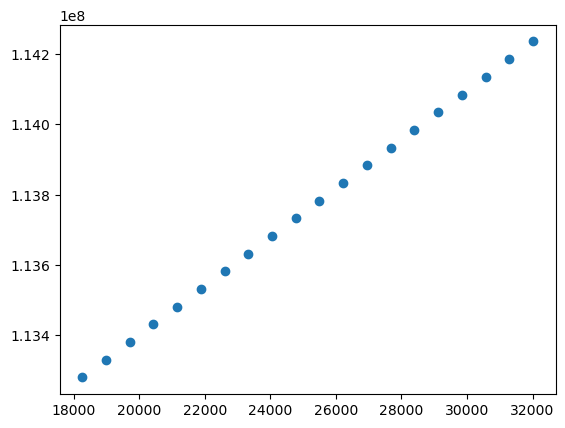

In [119]:
plt.scatter(np.diff(res.Qol)[1:], np.diff(res.Cost)[1:])